In [1]:
import pyarrow.parquet as pq
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import keras
print(keras.__version__)
from keras import backend as K
import tensorflow as tf
print(tf.__version__)
from keras.callbacks import LambdaCallback,EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from math import sqrt
from sklearn.metrics import confusion_matrix,f1_score,matthews_corrcoef,fbeta_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sn
from sklearn.utils import class_weight

Using TensorFlow backend.


2.3.1
2.0.0-rc1


In [2]:
df = pq.read_table(source='integratedData.parquet.gz').to_pandas()
display(df.head())

,date,precipitation_amount_mm,relative_humidity_%,specific_humidity_kg/kg,surface_downwelling_shortwave_flux_in_air_W m-2,wind_from_direction_Degrees Clockwise from north,wind_speed_m/s,max_air_temperature_K,min_air_temperature_K,burning_index_g_Unitless,dead_fuel_moisture_100hr_Percent,dead_fuel_moisture_1000hr_Percent,energy_release_component-g_Unitless,potential_evapotranspiration_mm,mean_vapor_pressure_deficit_kPa,fire_occurred,acres_burned,fire_name,longitude,latitude
0,1999-01-01,0.0,40.3,0.00589,138.0,123.0,1.6,293.1,281.1,24.0,16.0,15.5,34.0,1.7,0.74,False,NaN,None,-117.975000,33.566667
1,1999-01-01,0.0,39.8,0.00590,137.2,123.0,1.6,293.1,281.2,24.0,16.0,15.5,35.0,1.7,0.74,False,NaN,None,-117.933333,33.566667
2,1999-01-01,0.0,38.2,0.00580,137.2,123.0,1.7,293.2,281.2,26.0,15.2,14.9,37.0,1.7,0.77,False,NaN,None,-117.891667,33.566667
3,1999-01-01,0.0,36.4,0.00567,137.3,49.0,1.8,293.3,280.3,27.0,15.0,14.8,38.0,1.8,0.76,False,NaN,None,-117.850000,33.566667
4,1999-01-01,0.0,33.8,0.00538,137.3,49.0,1.9,293.2,279.9,29.0,13.3,13.6,43.0,1.9,0.80,False,NaN,None,-117.808333,33.566667


In [3]:
###********Check Fire occured in Months to drop some months of data********
fire_occured_df = df[df['fire_occurred']==True]
month_list = [0,0,0,0,0,0,0,0,0,0,0,0]
for item in fire_occured_df['date']:
    month_list[item.month-1] = month_list[item.month-1]+ 1;
print ("Fire Occurence in Each month across years")
print (month_list)

Fire Occurence in Each month across years
[14, 13, 9, 6, 217, 122, 296, 148, 87, 1220, 6, 29]


In [4]:
df_sorted = df.sort_values(['latitude', 'longitude','date'], ascending=[True,True,True])
df_sorted['month'] = df_sorted.apply(lambda row: row.date.month, axis = 1)
df_sorted['day']   = df_sorted.apply(lambda row: row.date.day, axis = 1)
#df_upd = df_sorted[(df_sorted['month']>4) & (df_sorted['month']<11)]

In [5]:
df_upd = df_sorted.reindex(columns= ['precipitation_amount_mm','relative_humidity_%','specific_humidity_kg/kg', \
 'surface_downwelling_shortwave_flux_in_air_W m-2','wind_from_direction_Degrees Clockwise from north', \
 'wind_speed_m/s','max_air_temperature_K', 'min_air_temperature_K','burning_index_g_Unitless', \
 'dead_fuel_moisture_100hr_Percent','dead_fuel_moisture_1000hr_Percent','energy_release_component-g_Unitless', \
 'potential_evapotranspiration_mm','mean_vapor_pressure_deficit_kPa',
 'longitude','latitude','month','day','fire_occurred','acres_burned','fire_name','date'])
df_upd.fire_occurred = df_sorted.fire_occurred.astype(int)
df_upd.head()

,precipitation_amount_mm,relative_humidity_%,specific_humidity_kg/kg,surface_downwelling_shortwave_flux_in_air_W m-2,wind_from_direction_Degrees Clockwise from north,wind_speed_m/s,max_air_temperature_K,min_air_temperature_K,burning_index_g_Unitless,dead_fuel_moisture_100hr_Percent,...,potential_evapotranspiration_mm,mean_vapor_pressure_deficit_kPa,longitude,latitude,month,day,fire_occurred,acres_burned,fire_name,date
1268,0.0,49.5,0.00653,155.3,348.0,2.6,290.7,281.0,26.0,17.2,...,1.7,0.47,-117.141667,32.483333,1,1,0,NaN,None,1999-01-01
2660,0.0,54.3,0.00656,157.5,358.0,2.3,291.3,281.1,24.0,17.2,...,1.7,0.51,-117.141667,32.483333,1,2,0,NaN,None,1999-01-02
4052,0.0,41.1,0.00581,160.8,38.0,3.3,293.4,279.9,29.0,16.8,...,2.4,0.73,-117.141667,32.483333,1,3,0,NaN,None,1999-01-03
5444,0.0,23.9,0.00437,160.7,62.0,2.3,295.4,281.9,28.0,14.6,...,2.6,1.20,-117.141667,32.483333,1,4,0,NaN,None,1999-01-04
6836,0.0,24.1,0.00556,160.7,347.0,2.5,294.4,282.2,30.0,13.2,...,2.4,0.94,-117.141667,32.483333,1,5,0,NaN,None,1999-01-05


In [6]:
undersample_grid_dict= {}
with open('log.txt', 'w') as f:
    lats = sorted(set(df_upd.latitude.values))
    lons = sorted(set(df_upd.longitude.values))

    loc_count = 0
    Fire_loc_count = 0
    NoFire_loc_count = 0
    for i in lats:
        for j in lons:
            mask = (df_upd['latitude']==i) & (df_upd['longitude']==j)
            if not df_upd[mask].empty:
                loc_count += 1;
                if 1 in df_upd[mask]['fire_occurred'].values:
                    Fire_loc_count += 1;
                else:
                    if i not in undersample_grid_dict.keys():
                        undersample_grid_dict[i] = []
                    if j not in undersample_grid_dict[i]:
                        undersample_grid_dict[i].append(j)
#                     print ("Dropping all data at ",i,j,file=f)
#                     df_upd.drop(sorted(df_upd[mask].index),inplace=True)
                    NoFire_loc_count += 1;

    print("Total grids are ",loc_count)
    print("Grids that had Fire", Fire_loc_count)
    print("Grids that didn't have Fire", NoFire_loc_count)

Total grids are  890
Grids that had Fire 478
Grids that didn't have Fire 412


In [7]:
df_upd.shape

(6826300, 22)

In [8]:
df_mod = df_upd.reset_index(drop=True)

In [9]:
#Normalize data
from sklearn.preprocessing import MinMaxScaler
x =     df_mod[df_mod.columns[~df_mod.columns.isin(['fire_occurred','acres_burned','fire_name','date'])]].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(x)
#norm_Df = pd.DataFrame(data = norm_x, columns = columns)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [10]:
#This function is called upon if the seq has fire and accordingly adds it to that fire group
def append_to_fire_seq(fire_dict,i,df_mod,lag):
#    print (i,len(fire_dict))
    idx = i + np.where(df_mod.iloc[i:i+lag]['fire_occurred']==1)[0][0]
    fire_name = df_mod.iloc[idx]['fire_name']
    check_date = pd.Timestamp.to_datetime64(df_mod.iloc[idx]['date'])
    if fire_name!=None:
        fire_name = str(df_mod.iloc[idx]['date'].year) + "_" + fire_name.lower() 
        if fire_name not in fire_dict.keys():
            fire_dict[fire_name] = []
#         if len(fire_dict[fire_name])!=0:
#             check_date2 = fire_dict[fire_name][0][0][-1]
#             #if ((check_date2-check_date).astype('timedelta64[D]')/np.timedelta64(1, 'D')) < -20:
#             if (check_date2 - check_date).days < -30:
#                 print ("Pls check this fire list", fire_name , "Seems fires occured more than 30 days apart")
        fire_dict[fire_name].append(df_mod.iloc[idx-lag:idx].values)
        fire_dict[fire_name].append(df_mod.iloc[idx]['fire_occurred'])
    else:
        print ("No Name for this fire happened in from ",idx-lag)

In [11]:
def undersample(lat,lon,year,month):
    undersample_grid_year_dict = {}
    if lat in undersample_grid_dict.keys():
        if lon in undersample_grid_dict[lat]:  #Grid never had fire. Let's add only one seq per month
            if (lat,lon) not in undersample_grid_year_dict.keys():
                undersample_grid_year_dict[(lat,lon)]= {}
            if year not in undersample_grid_year_dict[(lat,lon)].keys():
                undersample_grid_year_dict[(lat,lon)][year] = []   #This month and year for this Grid is seen first time.
            if month not in undersample_grid_year_dict[(lat,lon)][year]:
                undersample_grid_year_dict[(lat,lon)][year].append(month)
                #print (lat,lon,year,month)
                return 1
            else:
                return 0
    return 1  

In [20]:
#This function breaks the total dataset into small sequences
def create_seq(df_mod,lag):    
    print ("Every sequence will be",lag, "days long asking LSTM to predict a fire based on past",lag,"days of weather")
    global nofire_X,nofire_y,fire_dict
    nofire_X = []
    nofire_y = []
    fire_dict = {}
    for i in range(0,df_mod.shape[0],lag):
        if i+lag in df_mod.index:
            fire_occur_list = list(df_mod.iloc[i:i+lag].fire_occurred.values)
            if fire_occur_list.count(1)==1:          #Fire in Sequence
                append_to_fire_seq(fire_dict,i,df_mod,lag)
            elif fire_occur_list.count(1)==0:        #No Fire in Sequence
                if undersample(df_mod.iloc[i]['latitude'],df_mod.iloc[i]['longitude'],df_mod.iloc[i]['date'].year,df_mod.iloc[i]['month'])==1:
                    nofire_X.append(df_mod.iloc[i:i+lag].values)
                    nofire_y.append(df_mod.iloc[i+lag]['fire_occurred'])
            else:                                   #More than one fire in sequence. Maybe same or different fires
                indices = np.where(df_mod.iloc[i:i+lag]['fire_occurred']==1)[0]
                for item in indices:
                    append_to_fire_seq(fire_dict,i+item,df_mod,lag)
        else:
            print ("Can't create sequence from this index onwards", i)

In [13]:
#This function is called to retrieve sequences of a particular fire
def add_fire_seq_train_test (fire_names):
    X_list= []
    for fire in fire_names:
        for idx in range(0,len(fire_dict[fire]),2):
            X_list.append(fire_dict[fire][idx])
            if fire_dict[fire][idx+1]!=1:
                print ("Error: This is unexpected. Check the fire sequence for fire ", fire)
    return X_list

In [14]:
def comb_fire_and_nofire(nofire_X_train,fire_X_train,nofire_y_train,fire_y_train):
    a_len = len(nofire_X_train)
    b_len = len(fire_X_train)
    a_cnt = -1
    b_cnt = -1
    out_x_list = []
    out_y_list = []
    my_list = [0]*len(nofire_X_train) + [1]*len(fire_X_train)
    random.shuffle(my_list)
    for i in my_list:
        if i==0:
            a_cnt += 1
            out_x_list.append(nofire_X_train[a_cnt])
            out_y_list.append(nofire_y_train[a_cnt])
        else:
            #print (a_cnt,b_cnt)
            b_cnt += 1
            out_x_list.append(fire_X_train[b_cnt])
            out_y_list.append(fire_y_train[b_cnt])
    return out_x_list,out_y_list

In [15]:
def train_test_partition():
    smaller_seq_fires = []
    medium_seq_fires = []
    larger_seq_fires = []
    for item in sorted(fire_dict.keys()):
        if len(fire_dict[item])/2 < 5:
            smaller_seq_fires.append(item)
        elif len(fire_dict[item])/2 < 40:
            medium_seq_fires.append(item)
        else:
            larger_seq_fires.append(item)
    nofire_X_train, nofire_X_test, nofire_y_train, nofire_y_test = train_test_split(nofire_X, nofire_y, test_size=1/4, random_state=0,shuffle=True)        
    smaller_fire_train,smaller_fire_test = train_test_split(smaller_seq_fires,test_size=1/4, random_state=41,shuffle=True)
    medium_fire_train,medium_fire_test = train_test_split(medium_seq_fires,test_size=1/4, random_state=67,shuffle=True)
    larger_fire_train,larger_fire_test = train_test_split(larger_seq_fires,test_size=1/4, random_state=0,shuffle=True)
    fire_X_train = []
    fire_X_test  = []
    fire_X_train = fire_X_train + add_fire_seq_train_test(smaller_fire_train)
    fire_X_train = fire_X_train + add_fire_seq_train_test(medium_fire_train)
    fire_X_train = fire_X_train + add_fire_seq_train_test(larger_fire_train)
    fire_X_test = fire_X_test + add_fire_seq_train_test(smaller_fire_test)
    fire_X_test = fire_X_test + add_fire_seq_train_test(medium_fire_test)
    fire_X_test = fire_X_test + add_fire_seq_train_test(larger_fire_test)
    fire_y_train = [1] * len(fire_X_train)
    fire_y_test  = [1] * len(fire_X_test)
    print ("No. of Fires in Train set are", len(smaller_fire_train) + len(medium_fire_train) + len(larger_fire_train))
    print ("No. of Fire sequences in Train set are", len(fire_X_train))
    print ("No. of no-fire sequences in Train set are", len(nofire_X_train))
    print ("No. of Fires in Test set are", len(smaller_fire_test) + len(medium_fire_test) + len(larger_fire_test))
    print ("No. of Fire sequences in Test set are", len(fire_X_test))
    print ("No. of no-fire sequences in Test set are", len(nofire_X_test))
    print ("Larger sequences in Test",larger_fire_test)
    A,B = comb_fire_and_nofire(nofire_X_train,fire_X_train,nofire_y_train,fire_y_train)
    C,D = comb_fire_and_nofire(nofire_X_test,fire_X_test,nofire_y_test,fire_y_test)
    return A,B,C,D

In [16]:
from keras import backend as K
import tensorflow as tf

# Compatible with tensorflow backend

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

In [17]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

In [18]:
def train_model(X_train,X_test,y_train,y_test,input_node,hidden_node,hidden_node1,dropout,class_weight,loss_funtion,alpha,gamma,lag):
    input=()
    ##Build LSTM Model
    global model
    model = Sequential()
    model.add(LSTM(input_node, input_shape=(X_train[0].shape),activation='relu'))
    model.add(Dense(hidden_node, activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_node1, activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2, activation = 'softmax'))
    if (loss_funtion=='binary_crossentropy'):
        model.compile(loss='binary_crossentropy', optimizer='adam')     
    else:
        model.compile(loss=binary_focal_loss(alpha=alpha,gamma=gamma),optimizer='adam')
    #Fit the model
    train_label = np.array(y_train)
    y_invtrain = [1 - crap for crap in y_train]
    train_label_inv = np.array(y_invtrain)
    train_label_np = np.array((train_label_inv,train_label), order='F').T
    #train_label_np = np.array((train_label,train_label_inv), order='F').T

    history = model.fit(np.array(X_train),train_label_np,
                            epochs=25,validation_split = 0.1,
                            verbose=2, shuffle=False,
                            callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)],
                            class_weight=class_weight)
    #Visualize Training
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Training pattern')
    plt.legend()
    # make a prediction
    global y_pred, y_ppredt
    y_pred = model.predict(np.array(X_test))
    #Measure metrics
    y_ppredt=[]
    for i in y_pred:
        if i[0]<i[1]:
            y_ppredt.append(1)
        else:
            y_ppredt.append(0)
    f1 = f1_score(y_test, y_ppredt, average='macro')
    f2 = fbeta_score(y_test, y_ppredt, average='macro', beta=2)
    mcc = matthews_corrcoef(y_test, y_ppredt)
    disp = confusion_matrix(y_test,y_ppredt,labels=[1,0])
    with open("test.csv", "a") as myfile:
        temp_string = "Building LSTM of lag\t" + str(lag) + ";" \
                      "with input_node\t" + str(input_node)  + ";" \
                      "and hidden_node\t" + str(hidden_node) + ";" \
                      "and hidden_node1\t" + str(hidden_node1) + ";" \
                      "and dropout\t" + str(dropout) + "," \
                      "and class_weight\t" + str(class_weight) + ";" \
                      "and loss_funtion\t" + str(loss_funtion) + ";" \
                      "of alpha\t" + str(alpha) + ";"\
                      "and gamma\t" + str(gamma) + ";" \
                      "and received F1_Score:\t" + str(f1) + ";" \
                      "and received F2_Score:\t" + str(f2) + ";" \
                      "and MCC_Score:\t" + str(mcc) + ";" \
                      "of CM\t" + str(disp).replace('\n', '') + ";" + "\n"
        myfile.write(temp_string)
        print (temp_string)
    skplt.metrics.plot_confusion_matrix(y_test, y_ppredt,labels=[1,0])
    plt.show()

Every sequence will be 10 days long asking LSTM to predict a fire based on past 10 days of weather
Can't create sequence from this index onwards 6826290
No. of Fires in Train set are 220
No. of Fire sequences in Train set are 1705
No. of no-fire sequences in Train set are 511132
No. of Fires in Test set are 74
No. of Fire sequences in Test set are 462
No. of no-fire sequences in Test set are 170378
Larger sequences in Test ['2011_eagle', '2007_harris']
{0: 0.5017159639432343, 1: 146.1907069555302}
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 461553 samples, validate on 51284 samples
Epoch 1/25
 - 86s - loss: 0.0074 - val_loss: 0.0031
Epoch 2/25
 - 86s - loss: 0.0060 - val_loss: 0.0020
Epoch 3/25
 - 86s - loss: 0.0058 - val_loss: 0.0020
Epoch 4/25
 - 83s - loss: 0.0058 - val_loss: 0.0061
Epoch 5/25
 - 84s - loss: 0.0059 - val_loss: 0.0017
Epoch 6/25
 - 86s - loss: 0.0057 - val_loss: 0.0018
Epoch 7/25
 - 81s - loss: 0.0058 - val_l

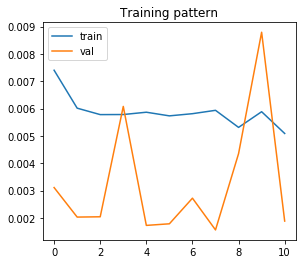

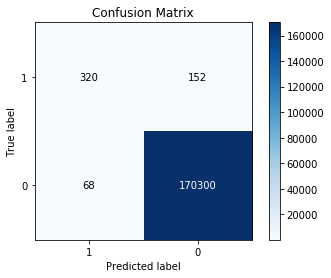

In [21]:
lag_list = [10]
for lag in lag_list:
    create_seq(df_mod,lag)
    X_train,y_train,X_test,y_test = train_test_partition()
    #Normalize the train datset
    X_train_norm = []
    for seq in X_train:
        fire_occurence = seq[:,18]
        temp = scaler.transform(seq[:,:18])
        temp = np.column_stack((temp,fire_occurence))
        X_train_norm.append(temp)

    #Normalize the train datset
    X_test_norm = []
    for seq in X_test:
        fire_occurence = seq[:,18]
        temp = scaler.transform(seq[:,:18])
        temp = np.column_stack((temp,fire_occurence))
        X_test_norm.append(temp)
        
    temp = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
    class_weight1 = dict(enumerate(temp))
    print (class_weight1)
    
    X_mod_test  = []
    X_mod_train = []
    y_mod_test  = []
    y_mod_train = []
    for idx,val in enumerate(X_train_norm):
        if np.any(val[:,17] == 1):
            val[:,17] = 0
        if np.any(val[:,17] != 1):
            X_mod_train.append(val)
            y_mod_train.append(y_train[idx])        

    for idx,val in enumerate(X_test_norm):
        if np.any(val[:,17] == 1):
            val[:,17] = 0
        if np.any(val[:,17] != 1):
            X_mod_test.append(val)
            y_mod_test.append(y_test[idx])    
            
    train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,10,10,10,0.1,class_weight1,'focal_loss',0.25,2,lag)
#     train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,5,5,5,0.1,{0: 0.5, 1: 800},'focal_loss',0.65,2,lag)
#     train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,5,5,5,0.1,class_weight1,'focal_loss',0.15,2,lag)
#     train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,5,5,5,0.1,{0: 0.5, 1: 40},'binary_crossentropy',0,0,lag)
#     train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,5,5,5,0.1,{0: 0.5, 1: 6},'binary_crossentropy',0,0,lag)
#     train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,5,5,5,0.1,{0: 0.5, 1: 800},'binary_crossentropy',0,0,lag)
#     train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,5,5,3,0.1,{0: 0.5, 1: 1600},'binary_crossentropy',0,0,lag)

Train on 461553 samples, validate on 51284 samples
Epoch 1/25
 - 83s - loss: 0.1851 - val_loss: 0.0641
Epoch 2/25
 - 86s - loss: 0.2473 - val_loss: 0.0877
Epoch 3/25
 - 85s - loss: 1.8673 - val_loss: 1.8113
Epoch 4/25
 - 87s - loss: 2.1365 - val_loss: 1.8113
Restoring model weights from the end of the best epoch
Epoch 00004: early stopping
Building LSTM of lag	10;with input_node	10;and hidden_node	10;and hidden_node1	10;and dropout	0.1,and class_weight	{0: 0.5, 1: 40};and loss_funtion	binary_crossentropy;of alpha	0;and gamma	0;and received F1_Score:	0.6462525498955165;and received F2_Score:	0.7145033499941122;and MCC_Score:	0.3469272469899666;of CM	[[   298    174] [  1239 169129]];



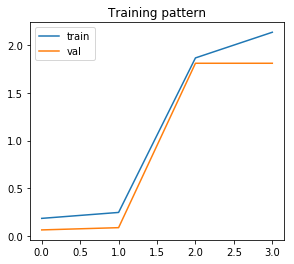

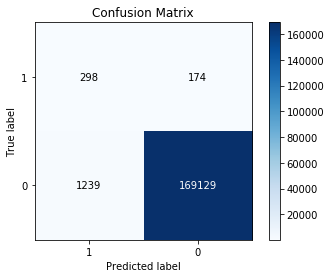

In [22]:
train_model(X_mod_train,X_mod_test,y_mod_train,y_mod_test,10,10,10,0.1,{0: 0.5, 1: 40},'binary_crossentropy',0,0,lag)